
# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
%matplotlib inline
from datetime import timedelta


import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('champagne.csv')
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [3]:
## Cleaning up the data
df.columns=["Month","Sales"]
df[df['Sales'].isnull()].index.tolist()


[105, 106]

In [4]:
## Drop last 2 rows with NaN values
df.drop([105,106],axis=0,inplace=True)
df.isnull().any()



Month    False
Sales    False
dtype: bool

In [5]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [6]:
df.set_index('Month',inplace=True)

In [7]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [8]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


## Step 2: Visualize the Data

<AxesSubplot:xlabel='Month'>

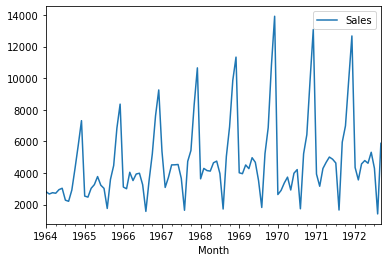

In [9]:
df.plot()
# clear upward trend and seasonality

In [10]:
### Testing For Stationarity

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [11]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.833593056327623
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Differencing

In [12]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)

In [13]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [14]:
df.head(14)

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [15]:
## Again test dickey fuller test (dropping NaN values)
adfuller_test(df['Sales First Difference'].dropna())

ADF Test Statistic : -7.189896448051003
p-value : 2.5196204473870433e-10
#Lags Used : 11
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

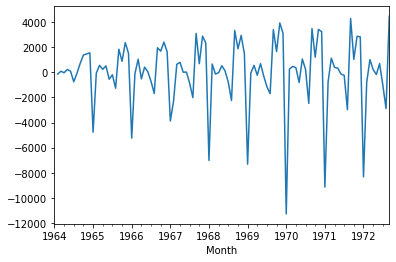

In [17]:
df['Sales First Difference'].plot()
# it looks stationary now

### Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

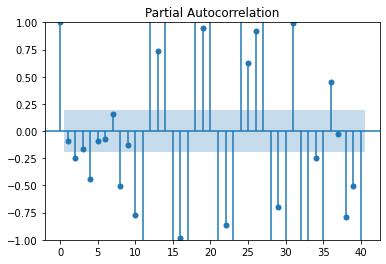

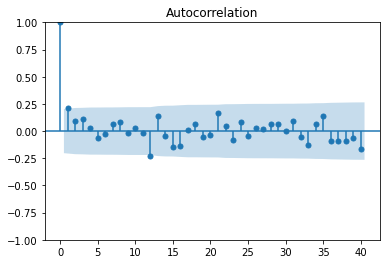

In [18]:
pacf = plot_pacf(df['Seasonal First Difference'].dropna(),lags=40)
acf = plot_acf(df['Seasonal First Difference'].dropna(),lags=40)

## ARIMA

In [18]:
# Lets first fit ARIMA model with
#p=1, d=1, q=0 or 1

train_end = datetime(1971,6,1)
test_end = datetime(1972,9,1)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [19]:
train_data = train_data[["Sales"]]

In [20]:
model=ARIMA(train_data,order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   90
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -813.015
Date:                Wed, 19 Oct 2022   AIC                           1632.031
Time:                        12:56:56   BIC                           1639.497
Sample:                    01-01-1964   HQIC                          1635.040
                         - 06-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4703      0.138      3.405      0.001       0.200       0.741
ma.L1         -0.9631      0.072    -13.348      0.000      -1.105      -0.822
sigma2      4.947e+06   5.96e+05      8.302      0.000    3.78e+06    6.11e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 5.47
Prob(Q):                              0.34   Prob(JB):                         0.06
Heteroskedasticity (H):               4.00   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Non-Rolling Forecast

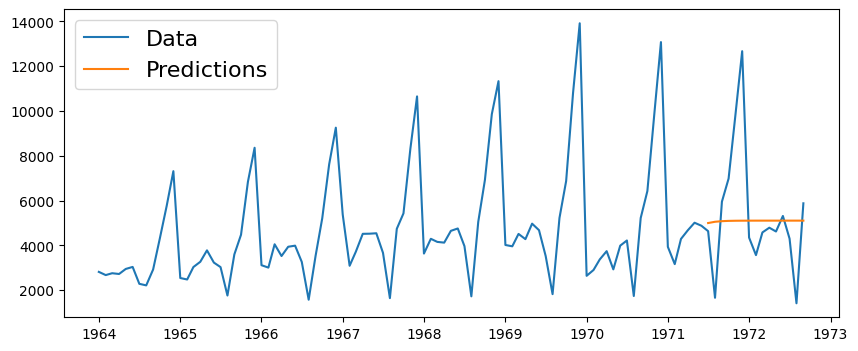

In [21]:
# forecast (non-rolling)
predictions = model_fit.forecast(len(test_data))
test_data["forecast"] = predictions

plt.figure(figsize=(10,4))
plt.plot(df['Sales'])
plt.plot(test_data['forecast'])
plt.legend(('Data', 'Predictions'), fontsize=16)

In [22]:
# Errors
test_data['residuals'] = test_data['Sales'] - test_data['forecast']
print('Mean Absolute Percent Error:', round(np.mean(abs(test_data['residuals']/test_data["Sales"])),4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(test_data['residuals']**2)),4))

Mean Absolute Percent Error: 0.4988
Root Mean Squared Error: 2760.6033


This out-of sample forecast converges to the mean in the long run. A better approach might be a rolling forecast instead.

## Rolling forecast

Text(0, 0.5, 'Production')

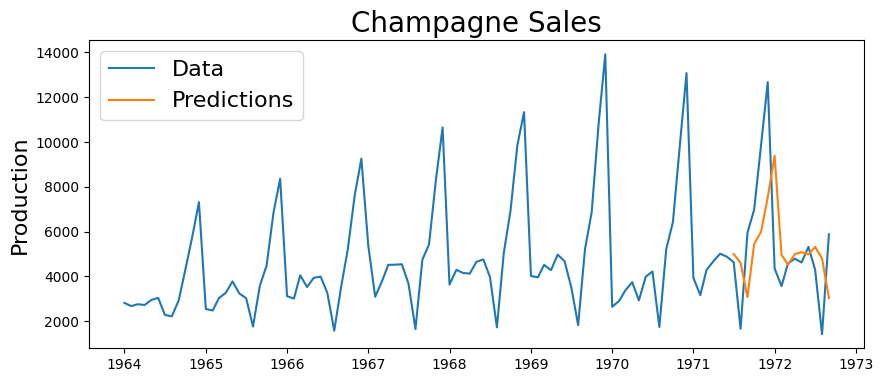

In [23]:
# rolling forecast taking into account actual data to predict next month
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    rolling_train_data = df[:train_end-timedelta(days=1)]
    model=ARIMA(rolling_train_data["Sales"],order=(1,1,1))
    model_fit = model.fit()
    pred = model_fit.forecast()
    test_data.loc[train_end,'rolling_forecast'] = pred.item()
    #rolling_predictions[train_end] = pred
    
plt.figure(figsize=(10,4))

plt.plot(df['Sales'])
plt.plot(test_data['rolling_forecast'])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Champagne Sales', fontsize=20)
plt.ylabel('Production', fontsize=16)

In [24]:
# Residuals
test_data['residuals'] = test_data['Sales'] - test_data['rolling_forecast']
print('Mean Absolute Percent Error:', round(np.mean(abs(test_data['residuals']/test_data["Sales"])),4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(test_data['residuals']**2)),4))

Mean Absolute Percent Error: 0.5495
Root Mean Squared Error: 2698.0978


## SARIMA
Now lets integrate the seasonal component.

In [27]:
model=sm.tsa.statespace.SARIMAX(train_data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12),freq='MS')
model_fit=model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -622.489
Date:                            Wed, 19 Oct 2022   AIC                           1254.978
Time:                                    12:57:23   BIC                           1266.697
Sample:                                01-01-1964   HQIC                          1259.666
                                     - 06-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3053      0.093      3.291      0.001       0.123       0.487
ma.L1         -0.9448      0.052    -18.050      0.000      -1.047      -0.842
ar.S.L12      -0.6094      0.269     -2.267      0.023      -1.136      -0.082
ma.S.L12       0.3598      0.280      1.283      0.199      -0.190       0.909
sigma2      5.533e+05   7.54e+04      7.343      0.000    4.06e+05    7.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 4.09
Prob(Q):                              0.60   Prob(JB):                         0.13
Heteroskedasticity (H):               1.91   Skew:                            -0.18
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

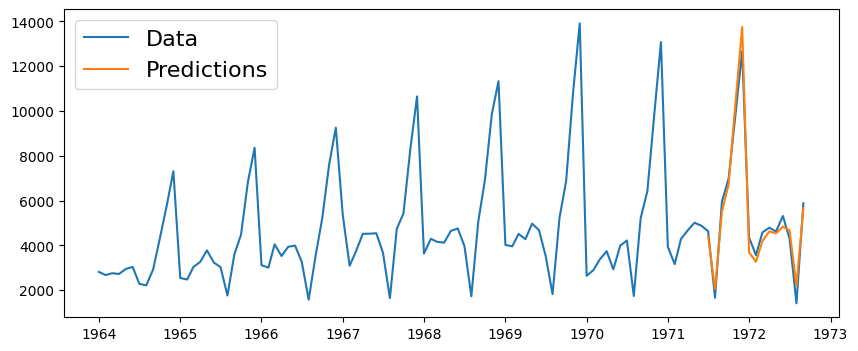

In [29]:
# SARIMA forecast
predictions = model_fit.forecast(len(test_data["forecast"]))
test_data["forecast"] = predictions


# Plot
plt.figure(figsize=(10,4))
plt.plot(df['Sales'])
plt.plot(test_data['forecast'])
plt.legend(('Data', 'Predictions'), fontsize=16)

In [81]:
# Residuals
test_data['residuals'] = test_data['Sales'] - test_data['forecast']
print('Mean Absolute Percent Error:', round(np.mean(abs(test_data['residuals']/test_data["Sales"])),4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(test_data['residuals']**2)),4))

Mean Absolute Percent Error: 0.1122
Root Mean Squared Error: 493.5783


The SARIMA with a seasonal component performs much better for this data set. Lets also try a rolling forecast here.

## Rolling forecast

Text(0, 0.5, 'Production')

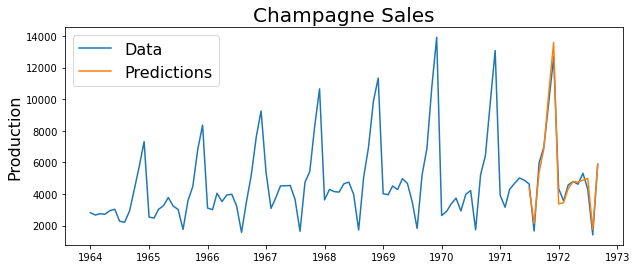

In [82]:
# rolling forecast taking into account actual data to predict next month
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    rolling_train_data = df[:train_end-timedelta(days=1)]
    model = sm.tsa.statespace.SARIMAX(rolling_train_data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12),freq='MS')
    model_fit = model.fit(disp=0)
    pred = model_fit.forecast()
    test_data.loc[train_end,'rolling_forecast'] = pred.item()
    
plt.figure(figsize=(10,4))
plt.plot(df['Sales'])
plt.plot(test_data['rolling_forecast'])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Champagne Sales', fontsize=20)
plt.ylabel('Production', fontsize=16)

In [83]:
# Residuals
test_data['residuals'] = test_data['Sales'] - test_data['rolling_forecast']
print('Mean Absolute Percent Error:', round(np.mean(abs(test_data['residuals']/test_data["Sales"])),4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(test_data['residuals']**2)),4))

Mean Absolute Percent Error: 0.0944
Root Mean Squared Error: 493.7787


This looks very promising now. Let's now predict 24 months into the future.

## Predict further into the future

In [84]:
# create new dates
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])
future_df.tail()

,Sales,Sales First Difference,Seasonal First Difference
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


<AxesSubplot:>

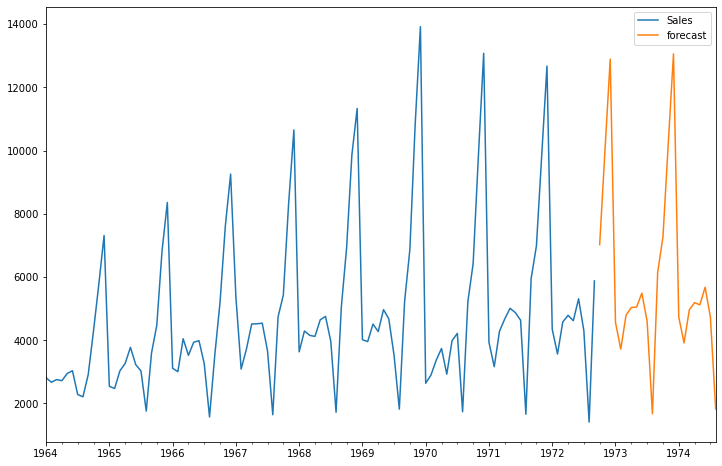

In [85]:
# fit SARIMA model on whole dataset and predict for new set of dates into the future
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12),freq='MS')
model_fit=model.fit(disp=0)
predictions = model_fit.forecast(len(future_dates))
future_df['forecast'] = predictions
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 